In this notebook, we're going to build a very simple neural network in PyTorch to do handwritten digit classification.
First, we'll start with some exploration of the MNIST dataset, explaining how we load and format the data.
We'll then jump into motivating and then implementing the logistic regression model, including the forward and backwards pass, loss functions, and optimizers.
After training the model, we'll evaluate how we did and visualize what we've learned.
Finally, we'll refactor our code in an object-oriented manner, using higher level APIs.

Before we get started, some imports for the packages we'll be using:

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### MNIST DATASET

The MNIST dataset is very popular machine learning dataset, consisting of 70000 grayscale images of handwritten digits, of dimensions 28x28. 
We'll be using it as our example dataset for this section of the tutorial, with the goal being to predict which digit is in each image.

![mnist](Figures/mnist.png)

The first (and often most important) step in machine learning is preparing the data.
This can include downloading, organizing, formatting, shuffling, pre-processing, augmenting, and batching examples so that they can be fed to a model.
The `torchvision` package makes this easy by implementing many of these, allowing us to put these datasets into a usable form in only a few lines of code.
First, let's download the train and test sets of MNIST. We will  use datasets already available in pytorch.

In [2]:
from torchvision import datasets, transforms

In [ ]:
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [4]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


As we'd expect, 60000 of the MNIST examples are in the train set, and the rest are in the test set.
We added the transform `ToTensor()` when formatting the dataset, to convert the input data from a Pillow `Image` type into a PyTorch `Tensor`. Tensors will eventually be the input type that we feed into our model. 

Let's look at an example image from the train set and its label.
Notice that the `image` tensor defaults to something 3-dimensional.
The "1" in the first dimension indicates that the image only has one channel (i.e. grayscale).
We need to get rid of this to visualize the image with `imshow`.

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


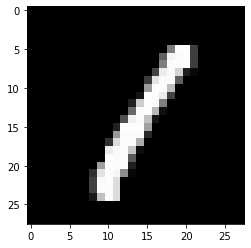

In [5]:
# Pick out the 4th (0-indexed) example from the training set
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

Lets load the data into two sets of dataloader, train and test.

In [6]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [7]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


In [8]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


The weight $W$ and bias $b$ make up the parameters of this model.
When we say that we want to "learn the model," what we're really trying to do is find good values for every element in $W$ and $b$.
Before we begin learning, we need to initialize our parameters to some value, as a starting point.
Here, we don't really know what the best values are, so we going to initialize $W$ randomly (using something called [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a.html)), and set $b$ to a vector of zeros.

In [9]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

As both `W` and `b` are parameters we wish to learn, we set `requires_grad` to `True`. 
This tells PyTorch's autograd to track the gradients for these two variables, and all the variables depending on `W` and `b`.

With these model parameters, we compute $y$:

In [10]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b

In [11]:
print(y[0,:])

tensor([-0.1446, -0.5859,  0.0889,  0.0568, -0.0487,  0.2234,  0.2219,  0.1354,
         0.0191,  0.2864], grad_fn=<SliceBackward>)


We can interpret these values (aka logits) $y$ as probabilities if we normalize them to be positive and add up to 1. In logistic regression, we do this with a softmax fucntion. PyTorch already has the softmax function in `torch.nn.functional`:

In [12]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] from equation: tensor([0.0823, 0.0529, 0.1039, 0.1006, 0.0905, 0.1188, 0.1187, 0.1088, 0.0969,
        0.1266], grad_fn=<SelectBackward>)
py[0] with torch.nn.functional.softmax: tensor([0.0823, 0.0529, 0.1039, 0.1006, 0.0905, 0.1188, 0.1187, 0.1088, 0.0969,
        0.1266], grad_fn=<SelectBackward>)


In [13]:
print(labels.shape)

torch.Size([100])


We don't know the values of 𝑊 and 𝑏 yet! Remember how we initialized them randomly? Before we adjust any of the weights, we need a way to measure how the model is doing. Specifically, we're going to measure how badly the model is doing. We do this with a loss function, which takes the model's prediction and returns a single number (i.e. a scalar) summarizing model performance. This loss will inform how we adjust the parameters of the model.

The loss we commonly use in classification is cross-entropy, a concept from information theory.Cross-entropy not only captures how correct (max probability corresponds to the right answer) the model's answers are, it also accounts for how confident (high confidence in correct answers) they are. This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers, instead of merely being satisfied with it being the argmax.

We focus here on supervised learning, a setting in which we have the labels. Our DataLoader automatically includes the corresponding labels for each of our inputs. Here are the labels from the first time we retrieved a minibatch:

In [14]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.3165946006774902
cross entropy with torch.nn.functional.cross_entropy: 2.3165948390960693


#### The backwards pass

Now that we have the loss as a way of quantifying how badly the model is doing, we can improve our model by changing the parameters in a way that minimizes the loss.
For neural networks, the common way of doing this is with backpropagation: we take the gradient of the loss with respect to $W$ and $b$ and take a step in the direction that reduces our loss.

If we were not using a deep learning framework like PyTorch, we would have to go through and derive all the gradients ourselves by hand, then code them into our program. 
We certainly still could.
However, with modern auto-differentiation libraries, it's much faster and easier to let the computer do it.

First, we need to create an optimizer.
There are many choices, but since logistic regression is fairly simple, we'll use standard stochastic gradient descent (SGD)

In [15]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

When we created our parameters $W$ and $b$, we indicated that they require gradients.
To compute the gradients for $W$ and $b$, we call the `backward()` function on the cross-entropy loss.

In [16]:
cross_entropy.backward()

In [17]:
b.grad

tensor([-0.0204, -0.0077, -0.0463,  0.0229, -0.0121,  0.0516, -0.0153, -0.0203,
         0.0405,  0.0072])

In [18]:
optimizer.step()

In [19]:
b

tensor([ 0.0020,  0.0008,  0.0046, -0.0023,  0.0012, -0.0052,  0.0015,  0.0020,
        -0.0040, -0.0007], requires_grad=True)

At this point, we've trained the model on 100 examples out of the 60000 in the training set.
We're going to need to repeat this process, for more of the data.

One more thing to keep in mind though: gradients calculated by `backward()` don't override the old values; instead, they accumulate.
Therefore, you'll want to clear the gradient buffers before you compute gradients for the next minibatch.

In [20]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([-0.0204, -0.0077, -0.0463,  0.0229, -0.0121,  0.0516, -0.0153, -0.0203,
         0.0405,  0.0072])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


#### Model Training

To train the model, we just need repeat what we just did for more minibatches from the training set.
As a recap, the steps were:
1. Draw a minibatch
2. Zero the gradients in the buffers for `W` and `b`
3. Perform the forward pass (compute prediction, calculate loss)
4. Perform the backward pass (compute gradients, perform SGD step)

Going through the entire dataset once is referred to as an epoch.
In many cases, we train neural networks for multiple epochs, but here, a single epoch is enough.
We also wrap the train_loader with `tqdm`.
This isn't neccessary, but it adds a handy progress bar so we can track our training progress.

In [21]:
# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

#### Testing

Now let's see how we did! 
For every image in our test set, we run the data through the model, and take the digit in which we have the highest confidence as our answer. 
We then compute an accuracy by seeing how many we got correct.
We're going to wrap evaluation with `torch.no_grad()`, as we're not interested in computing gradients during evaluation.
By turning off the autograd engine, we can speed up evaluation.

In [23]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9013000130653381


we can actually visualize what the model's learning by simply plotting the weights. The results look pretty reasonable:


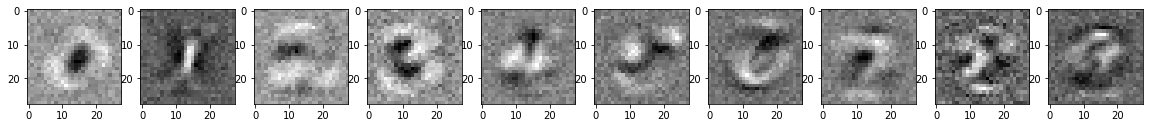

In [24]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

An accuracy score of 91% is not bad for starting out. However, with pytorch, we do not need to worry about writing our own classes for the operations we did. Lets take a look at the torch.nn module:

In [25]:
import torch.nn as nn

In [27]:
lin = nn.Linear(784, 10)
print("Linear parameters: {}".format([p.shape for p in lin.parameters()]))
x_rand = torch.randn(1,784)
y = lin(x_rand)
print(y.shape)

Linear parameters: [torch.Size([10, 784]), torch.Size([10])]
torch.Size([1, 10])


In [31]:
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

In [32]:
model = MNIST_Logistic_Regression()
y = model(x_rand)
print("The model: \n{}".format(model))
print("\nParameters: \n{}".format(list(model.parameters())))
print("\nOutput shape: \n{}".format(y.shape))

The model: 
MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

Parameters: 
[Parameter containing:
tensor([[-0.0081,  0.0245, -0.0041,  ..., -0.0346, -0.0121, -0.0302],
        [-0.0344, -0.0186,  0.0055,  ..., -0.0293, -0.0189,  0.0142],
        [ 0.0168, -0.0019, -0.0127,  ..., -0.0156,  0.0321,  0.0183],
        ...,
        [-0.0124, -0.0291, -0.0093,  ...,  0.0160,  0.0177, -0.0055],
        [ 0.0343,  0.0139, -0.0321,  ...,  0.0163, -0.0211,  0.0342],
        [ 0.0278, -0.0067, -0.0165,  ..., -0.0337, -0.0127,  0.0231]],
       requires_grad=True), Parameter containing:
tensor([ 0.0205,  0.0008, -0.0051, -0.0202, -0.0083, -0.0072,  0.0048, -0.0196,
        -0.0012,  0.0199], requires_grad=True)]

Output shape: 
torch.Size([1, 10])
